<a href="https://colab.research.google.com/github/vinikev/mvp/blob/main/MVP_ViniciusMonteiro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificando Imagens de Folhas de Café Doentes Utilizando CNNs
Durante a execução desse projeto, iremos avaliar a saúde de folhas de café com base em imagens utilizando classificação binária.
O dataset escolhido apresenta dois elementos principais:

*   Um diretório contendo 1560 imagens de folhas de café saudáveis e doentes.
*   Um arquivo `.xlsx` que rotula cada uma das imagens em dois níveis: **Saudável** ou **Doente**. No caso de **Doente**, informa também qual a provável doença.

Para essa aplicação, iremos usar apenas o primeiro rótulo, sem nos preocupar com qual doença aquela imagem retrata.  

O dataset escolhido foi o **RoCoLe.Original**.

Já como CNNs serão testadas os modelos **MobileNetV2**, **VGG19** e **ResNet50**.
Cada uma dessas redes apresenta um tamanho, complexidade e aplicação principal diferente.


# Importação das bibliotecas
Primeiro iremos realizar a importação das bibliotecas utilizadas no programa


*   **kagglehub**: Biblioteca para baixar o dataset
*   **os**: Biblioteca para manipulação de diretórios
*   **pandas**: Biblioteca para manipulação de dados
*   **random**: Biblioteca para nos auxiliar no processo de **data augmentation**
*   **tensorflow**: Biblioteca que contém os modelos de CNNs escolhidos
*   **numpy**: Biblioteca de arrays multidimensionais
*   **matplotlib**: Biblioteca para construção de gráficos



In [ ]:
# Importação das bibliotecas
import kagglehub
import os
import pandas as pd
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2, VGG19, ResNet50
from keras.regularizers import l2

# Importanto do dataset
Nesta etapa, estamos realizando a importação do dataset escolhido e movendo-o para um diretório específico, apenas para facilitar o acesso aos dados.

In [ ]:
#Importando o dataset e movendo para um diretório escolhido dentro do google collab

# Fazer o download do dataset escolhido
path = kagglehub.dataset_download("diegopgonzlez/rocoleoriginal")

# Definir o novo caminho onde deseja salvar o dataset
custom_path = "/content/dataset"

# Criar a pasta se ela não existir
!mkdir -p {custom_path}

# Mover os arquivos do dataset para a nova pasta
!mv {path}/* {custom_path}/

print("Os arquivos foram movidos para o diretório:", custom_path, "com sucesso!")

100%|██████████| 2.09G/2.09G [01:16<00:00, 29.4MB/s]

Extracting files...


Os arquivos foram movidos para o diretório: /content/dataset com sucesso!


# Data Augmentation
Como nosso dataset possui apenas **1560** imagens, nos primeiros testes obtivemos uma performance muito ruim de todas as redes.

Iremos, então, realizar um processo de *data augmentation* para expandir o número de amostras disponíveis para treinamento, validação e teste.

Para realizar essa expansão, aplicaremos rotação e alteração de brilho aleatórios em cada uma das imagens do dataset 10 vezes, totalizando **15.600** imagens ao final do processo. Além disso, precisaremos rotular essas novas imagens para que possam ser corretamente utilizadas no processo de treinamento.

In [ ]:
# Definição dos diretórios
original_images_dir = "/content/dataset/Photos"
augmented_images_dir = "/content/dataset/NewPhotos"

#Cria o novo diretório caso não exista
os.makedirs(augmented_images_dir, exist_ok=True)

# Carregar rótulos
annotations = pd.read_excel("/content/dataset/Annotations/RoCoLe-classes.xlsx")

# Função de augmentação
def augment_image(image_path, output_dir, label, count):
    image = Image.open(image_path)
    augmented_images = []

    for i in range(count):
        # Transformações
        angle = random.randint(-30, 30)
        brightness = random.uniform(0.7, 1.3)
        image_aug = image.rotate(angle)
        enhancer = ImageEnhance.Brightness(image_aug)
        image_aug = enhancer.enhance(brightness)

        # Salvar nova imagem
        new_image_name = f"aug_{i}_{os.path.basename(image_path)}"
        new_image_path = os.path.join(output_dir, new_image_name)
        image_aug.save(new_image_path)
        augmented_images.append(new_image_name)

    return augmented_images

# Aumentar dataset
new_annotations = []
for index, row in annotations.iterrows():
    image_path = os.path.join(original_images_dir, row["File"])
    label = row["Binary.Label"]

    # Criar 10 versões para cada imagem original
    augmented_images = augment_image(image_path, augmented_images_dir, label, count=10)

    for aug_img in augmented_images:
        new_annotations.append({"File": aug_img, "Binary.Label": label})

# Salvar novas anotações
augmented_annotations = pd.DataFrame(new_annotations)
augmented_annotations.to_excel("/content/dataset/Annotations/anotacoes_augmentadas.xlsx", index=False)

print("Dataset aumentado com sucesso!")

# Carregar os arquivos e realizar a divisão
Nesta etapa, estamos carregando as imagens do dataset e o arquivo com os rótulos.

Em seguida, visualizamos a estrutura do arquivo `.xlsx` e realizamos a divisão do dataframe em **80%** para treino, **10%** para validação e **10%** para teste.

**Observação**: Não iremos utilizar validação cruzada neste cenário pois aumentaria muito o tempo de execução que já é alto. Além disso, temos uma validação do tipo **holdout** para avaliar o desempenho do modelo durante o treinamento.

In [ ]:
# Carregar as imagens do dataset
image_dir = '/content/dataset/NewPhotos'

# Carregar o arquivo Excel que contém os rótulos
excel_file = '/content/dataset/Annotations/anotacoes_augmentadas.xlsx'
df = pd.read_excel(excel_file)

# Verificar como os dados estão organizados
print(df.head())  # Exibir as primeiras linhas do arquivo


# Divisão das imagens em dataframe de treino,validação e teste (80%/10%/10%)
train_df = df.sample(frac=0.8, random_state=42)
remaining_df = df.drop(train_df.index)
val_df = remaining_df.sample(frac=0.5, random_state=42)
test_df = remaining_df.drop(val_df.index)

# Definição das funções
Nestas etapas, são definidas as duas principais funções relacionadas aos modelos.
A primeira função é responsável por carregar os modelos pré-treinados e realizar algumas alterações para que eles se adequem melhor ao nosso cenário.
Dentre essas mudanças, vale destacar:

*   Congelamento do aprendizado dos neurônios até a camada 20, o que acelera o processo de treinamento mantendo uma boa performance. Além disso, as primeiras camadas são responsáveis por capturar características genéricas, como bordas, texturas e formas.
*   Adição de novas camadas ao final do modelo base, com o objetivo de melhorar o desempenho para o nosso caso específico.

In [ ]:
#Definição das funções que serão utilizadas ao longo do código

# Função para criar o modelo usando como base redes neurais conhecidas. Essa função recebe como parâmetro um modelo base e tem fixo o input_shape adequado para as redes neurais testadas
def create_model(base_model_class, input_shape=None):
    # Tamanhos padrão de entrada esperado para cada rede
    default_shapes = {
        MobileNetV2: (224, 224, 3),
        ResNet50: (224, 224, 3),
        VGG19: (224, 224, 3)
    }

    if input_shape is None and base_model_class in default_shapes:
        input_shape = default_shapes[base_model_class]

    # Carregar a base (modelo pré-treinado)
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    # Congelar o aprendizado dos neurônios das 20 primeiras camadas do modelo
    for layer in base_model.layers[:20]:
        layer.trainable = False
    for layer in base_model.layers[20:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print(model.summary())

    return model


# Função para treinar/validar um modelo
def train_model(model, train_data, validation_data, epochs=10):
    return model.fit(train_data, epochs=epochs, validation_data=validation_data)



# Normalização e associção imagem/rótulo
Nesta etapa, realizamos o processo de normalização dos pixels das imagens de entrada. Um pixel pode receber um valor de cor que varia de 0 a 255. Com o processo de normalização, redefinimos essa escala para 0 a 1, facilitando o processo de aprendizado.

Além disso, nesta etapa também estamos gerando os lotes de treino, validação e teste (com o tamanho esperado pela rede), das imagens já associadas ao seu respectivo rótulo.

In [ ]:
# Normalização dos pixels da imagem de entrada
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Gera batches de imagens com rótulos com base nos dados fornecidos no dataframe train_df
train_data = train_datagen.flow_from_dataframe(
    dataframe=train_df, # Dataframe de treino
    directory=image_dir, # Diretório de imagens
    x_col='File', # Coluna com o nome das imagens
    y_col='Binary.Label', # Coluna com o rótulo das imagens
    target_size=(224, 224), # Redimensiona as imagens para 224x224 px
    batch_size=64, #Tamanho do lote
    class_mode='binary' # Define o tipo de rótulo no caso 0 ou 1
)
# Gera batches de imagens com rótulos com base nos dados fornecidos no dataframe val_df
validation_data = validation_datagen.flow_from_dataframe(
    dataframe=val_df, # Dataframe de validação
    directory=image_dir, # Diretório de imagens
    x_col='File', # Coluna com o nome das imagens
    y_col='Binary.Label', # Coluna com o rótulo das imagens
    target_size=(224, 224), # Redimensiona as imagens para 224x224 px
    batch_size=64, #Tamanho do lote
    class_mode='binary' # Define o tipo de rótulo no caso 0 ou 1
)
# Gera batches de imagens com rótulos com base nos dados fornecidos no dataframe test_df
test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df, # Dataframe de teste
    directory=image_dir, # Diretório de imagens
    x_col='File', # Coluna com o nome das imagens
    y_col='Binary.Label', # Coluna com o rótulo das imagens
    target_size=(224, 224), # Redimensiona as imagens para 224x224 px
    batch_size=64, #Tamanho do lote
    class_mode='binary', # Define o tipo de rótulo no caso 0 ou 1
    shuffle=False
)

# Definição das CNNs
Nesta etapa, definimos um dicionário com os modelos pré-treinados que iremos avaliar e chamamos a função `create_model` para a compilação dos modelos.

Foram selecionados três modelos de CNNs

| Arquitetura  | Tamanho/Complexidade | Eficiência Computacional | Aplicação Principal                          |
|--------------|----------------------|--------------------------|----------------------------------------------|
| MobileNetV2  | Pequena              | Alta                     | Dispositivos móveis e sistemas embarcados   |
| ResNet50     | Grande               | Baixa                    | Benchmarking e aprendizado transferido      |
| VGG19        | Média                | Média                    | Tarefas complexas e redes profundas         |



A ideia será testar como cada modelo responde quando submetido as mesmas condições



In [ ]:
# Dicionário com os modelos de redes neurais que serão testadas
models_dict = {
    'MobileNetV2': create_model(MobileNetV2),
    'VGG19': create_model(VGG19),
    'ResNet50': create_model(ResNet50)
}

# Treinamento e teste de cada CNN
Nesta etapa, é realizado o processo de treinamento e teste de cada CNN definida na etapa anterior.

Utilizando a função `train_model`, definida anteriormente, realizamos o processo de treinamento de cada rede neural por um total de 10 épocas, passando como parâmetros os dataframes de treino e validação que foram separados anteriormente.

Após o treinamento de todos os modelos, é exibido o nome do modelo que obteve a maior acurácia de treinamento, juntamente com o valor.

Somente após isso, é realizado o teste para cada uma das redes neurais. Logo em seguida, é exibido também o nome do modelo que obteve a maior acurácia de teste, juntamente com o valor.

Devido ao nível de complexidade do problema apresentado não foi nessecário realizar a criação de ensembles. Melhores resultados para cada modelo podem ser alcançados com a customização individual de hiperparâmetros.

In [ ]:
# Dicionário que armazena os resultados do treinamento de cada modelo testado
history_dict = {}

# Loop para treinar cada modelo diferente
for model_name, model in models_dict.items():
    print(f"Treinando modelo: {model_name}")
    history_dict[model_name] = train_model(model, train_data, validation_data, epochs=10)

# Comparar a acurácia dos modelos para encontrar a melhor
accuracies = {model_name: history_dict[model_name].history['accuracy'][-1] for model_name in history_dict}
best_model_name = max(accuracies, key=accuracies.get)

print("Modelo com melhor acurácia de treino:", best_model_name)
print(f"Acurácia: {accuracies[best_model_name]}")

# Avaliar os modelos no conjunto de teste
test_results = {}

for model_name, model in models_dict.items():
    print(f"Testando modelo: {model_name}")
    test_results[model_name] = model.evaluate(test_data)
    print(f"{model_name} - Perda de teste: {test_results[model_name][0]} | Acurácia de teste: {test_results[model_name][1]}")

# Comparar os resultados do teste
test_accuracies = {model_name: test_results[model_name][1] for model_name in test_results}
best_test_model_name = max(test_accuracies, key=test_accuracies.get)

print("Modelo com melhor acurácia de teste:", best_test_model_name)
print(f"Acurácia: {test_accuracies[best_test_model_name]}")



# Exibindo os processos de treinamento/validação e teste como gráficos
Nesta parte, iremos utilizar a biblioteca `matplotlib` para exibir o desempenho de cada modelo ao longo dos processos de treinamento/validação e teste.

Para cada modelo, serão gerados 2 gráficos diferentes, sendo eles:

Gráfico contendo a comparação entre as acurácias de treino e de validação ao longo das épocas.
Gráfico contendo a comparação entre as perdas de treino e de validação ao longo das épocas.

A **acurácia** de um modelo mede a proporção de previsões corretas feitas pelo modelo em relação ao total das previsões. É de extrema importância para avaliarmos o acerto do nosso modelo.

Já a **perda** quantifica o erro do modelo. Ou seja, quando o modelo realiza uma previsão errada é calculada a diferença entre a previsão do modelo e os rótulos reais das imagens. Como utilizamos modelos base pré-treinados em todos os casos a perda é definida com base na **binary_crossentropy** já que nosso problema se trata de classificação binária (saudável ou doente).

In [ ]:

# Gerar gráficos para cada modelo
for model_name, history in history_dict.items():
    # Figura da acurácia
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Acurácia de treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
    plt.title(f'Comparação de acurácia - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{model_name}_accuracy.png')  # Salva o gráfico como imagem
    plt.show()  # Exibe o gráfico
    plt.close()  # Fecha a figura para evitar sobreposição

    # Figura da perda (loss)
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Perda de treino')
    plt.plot(history.history['val_loss'], label='Perda de validação')
    plt.title(f'Comparação de perda - {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'{model_name}_loss.png')  # Salva o gráfico como imagem
    plt.show()  # Exibe o gráfico
    plt.close()  # Fecha a figura para evitar sobreposição

print("Imagens salvas para cada modelo testado com métricas de acurácia e perda.")

# Conclusão
Durante o código, realizamos os seguintes passos:

* Importamos o dataset escolhido para o Colab.
* Realizamos o processo de data augmentation, buscando aumentar o número de amostras disponíveis.
* Dividimos essas amostras em 80/10/10, sendo treinamento, validação e teste, respectivamente.
* Importamos os modelos pré-treinados MobileNetV2, VGG19 e ResNet50.
* Customizamos esses modelos, adicionando novas camadas e congelando o aprendizado das 20 primeiras camadas.
* Submetemos cada modelo a um processo de treinamento com validação por 10 épocas.
* Testamos cada modelo para avaliar seus resultados em novos cenários.
* Plotamos gráficos para representar o processo de aprendizado de cada modelo.

Ao final dessas etapas (na minha execução), foi encontrado o seguinte cenário:

**Treinando modelo: MobileNetV2**

**Epoch 1/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 723s 4s/step - accuracy: 0.9035 - loss: 0.9351 - val_accuracy: 0.6955 - val_loss: 2.8199

**Epoch 2/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 663s 3s/step - accuracy: 0.9822 - loss: 0.0980 - val_accuracy: 0.8327 - val_loss: 2.2277

**Epoch 3/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 659s 3s/step - accuracy: 0.9861 - loss: 0.0521 - val_accuracy: 0.4974 - val_loss: 9.3466

**Epoch 4/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 652s 3s/step - accuracy: 0.9896 - loss: 0.0362 - val_accuracy: 0.7333 - val_loss: 2.2844

**Epoch 5/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 661s 3s/step - accuracy: 0.9934 - loss: 0.0237 - val_accuracy: 0.8045 - val_loss: 0.9516

**Epoch 6/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 651s 3s/step - accuracy: 0.9913 - loss: 0.0354 - val_accuracy: 0.7910 - val_loss: 1.1826

**Epoch 7/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step - accuracy: 0.9957 - loss: 0.0224 - val_accuracy: 0.7974 - val_loss: 1.0912

**Epoch 8/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 663s 3s/step - accuracy: 0.9928 - loss: 0.0278 - val_accuracy: 0.7494 - val_loss: 1.5741

**Epoch 9/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 677s 3s/step - accuracy: 0.9952 - loss: 0.0204 - val_accuracy: 0.8808 - val_loss: 0.7318

**Epoch 10/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 664s 3s/step - accuracy: 0.9922 - loss: 0.0318 - val_accuracy: 0.8699 - val_loss: 1.3973


**Treinando modelo: ResNet50**

**Epoch 1/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 2144s 11s/step - accuracy: 0.6239 - loss: 1.3661 - val_accuracy: 0.4981 - val_loss: 1.9788

**Epoch 2/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 2139s 11s/step - accuracy: 0.7716 - loss: 0.5294 - val_accuracy: 0.5026 - val_loss: 4.9808

**Epoch 3/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1981s 10s/step - accuracy: 0.8583 - loss: 0.3620 - val_accuracy: 0.6731 - val_loss: 0.6248

**Epoch 4/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1791s 9s/step - accuracy: 0.8990 - loss: 0.2660 - val_accuracy: 0.8115 - val_loss: 0.4130

**Epoch 5/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1795s 9s/step - accuracy: 0.9327 - loss: 0.1821 - val_accuracy: 0.6263 - val_loss: 1.5557

**Epoch 6/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1795s 9s/step - accuracy: 0.9513 - loss: 0.1389 - val_accuracy: 0.6641 - val_loss: 1.3229

**Epoch 7/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1798s 9s/step - accuracy: 0.9666 - loss: 0.0997 - val_accuracy: 0.8173 - val_loss: 0.5907

**Epoch 8/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1814s 9s/step - accuracy: 0.9724 - loss: 0.0779 - val_accuracy: 0.8410 - val_loss: 0.6899

**Epoch 9/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1800s 9s/step - accuracy: 0.9837 - loss: 0.0583 - val_accuracy: 0.9128 - val_loss: 0.2308

**Epoch 10/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1798s 9s/step - accuracy: 0.9805 - loss: 0.0609 - val_accuracy: 0.8622 - val_loss: 0.4643



**Treinando modelo: VGG19**

**Epoch 1/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1467s 8s/step - accuracy: 0.5916 - loss: 1.3385 - val_accuracy: 0.7686 - val_loss: 0.5983

**Epoch 2/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1503s 8s/step - accuracy: 0.7525 - loss: 0.6016 - val_accuracy: 0.8032 - val_loss: 0.4792

**Epoch 3/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1648s 8s/step - accuracy: 0.7875 - loss: 0.4987 - val_accuracy: 0.8224 - val_loss: 0.4226

**Epoch 4/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1726s 9s/step - accuracy: 0.8093 - loss: 0.4448 - val_accuracy: 0.8429 - val_loss: 0.3854

**Epoch 5/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1784s 9s/step - accuracy: 0.8329 - loss: 0.3987 - val_accuracy: 0.8686 - val_loss: 0.3350

**Epoch 6/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1609s 8s/step - accuracy: 0.8655 - loss: 0.3499 - val_accuracy: 0.8788 - val_loss: 0.3216

**Epoch 7/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1574s 8s/step - accuracy: 0.8780 - loss: 0.3250 - val_accuracy: 0.8891 - val_loss: 0.2886

**Epoch 8/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1699s 9s/step - accuracy: 0.9031 - loss: 0.2726 - val_accuracy: 0.8994 - val_loss: 0.2745

**Epoch 9/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1745s 9s/step - accuracy: 0.9118 - loss: 0.2498 - val_accuracy: 0.9192 - val_loss: 0.2237

**Epoch 10/10**
195/195 ━━━━━━━━━━━━━━━━━━━━ 1682s 9s/step - accuracy: 0.9218 - loss: 0.2284 - val_accuracy: 0.9237 - val_loss: 0.2146


Modelo com melhor acurácia de treino: **MobileNetV2**
Acurácia: 0.9923878312110901

Testando modelo: **MobileNetV2**
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8792 - loss: 1.3086
MobileNetV2 - Perda de teste: 1.6274865865707397 | Acurácia de teste: 0.8583333492279053


Testando modelo: **ResNet50**
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8752 - loss: 0.4064
ResNet50 - Perda de teste: 0.44147807359695435 | Acurácia de teste: 0.8634615540504456


Testando modelo: **VGG19**
25/25 ━━━━━━━━━━━━━━━━━━━━ 159s 6s/step - accuracy: 0.9090 - loss: 0.2396
VGG19 - Perda de teste: 0.21359746158123016 | Acurácia de teste: 0.9256410002708435

Modelo com melhor acurácia de teste: **VGG19**
Acurácia: 0.9256410002708435

##**MobileNetV2**
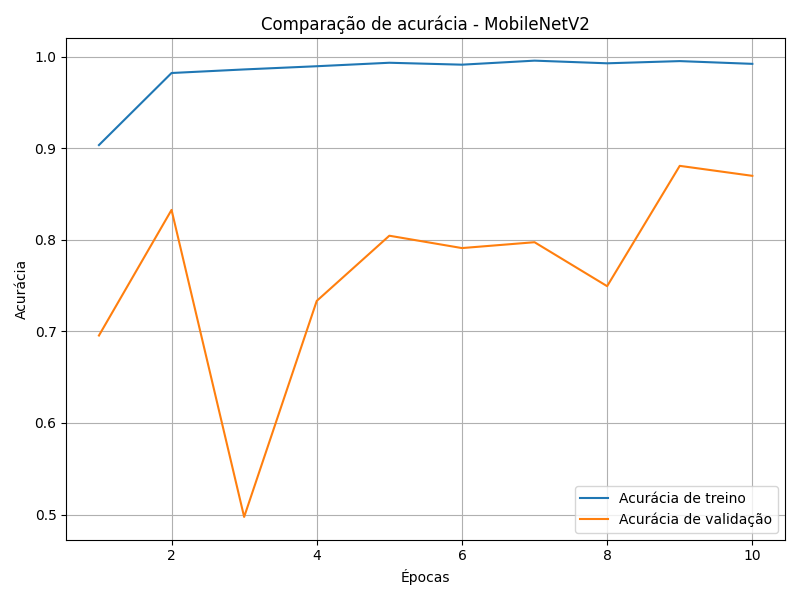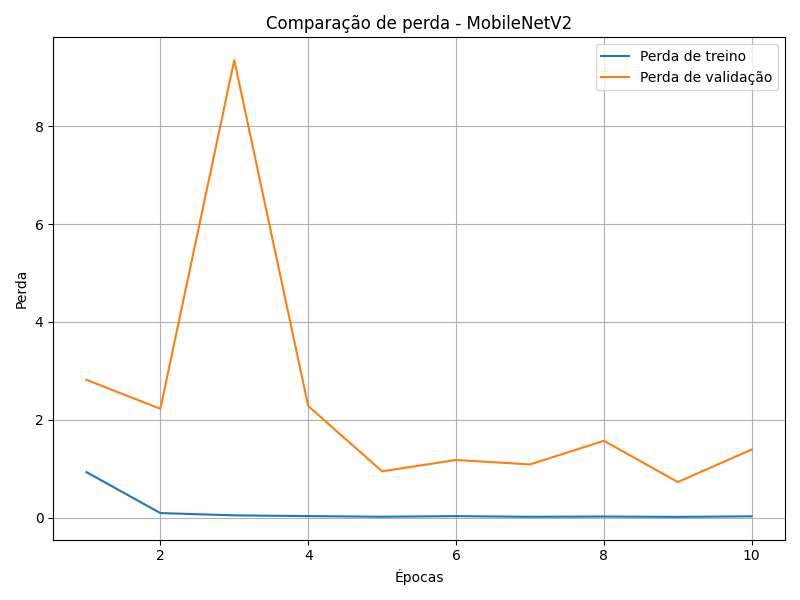

##**ResNet50**
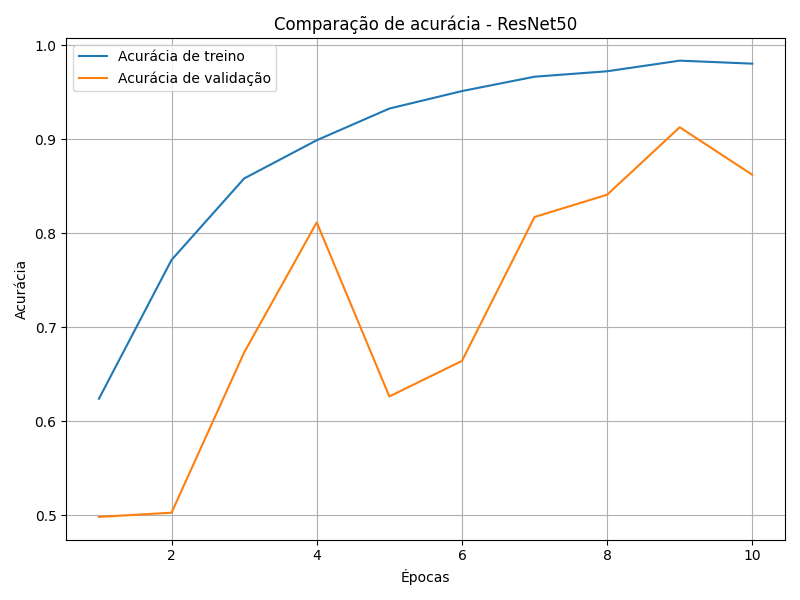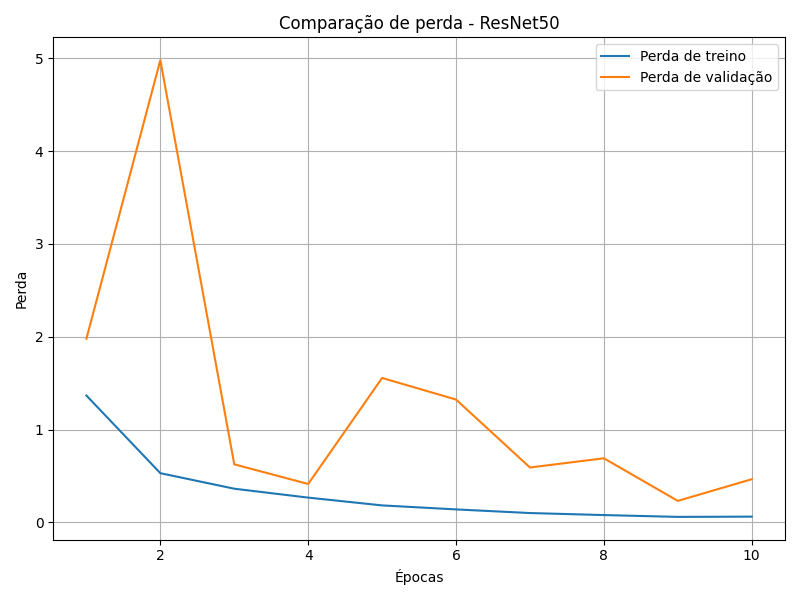

##**VGG19**
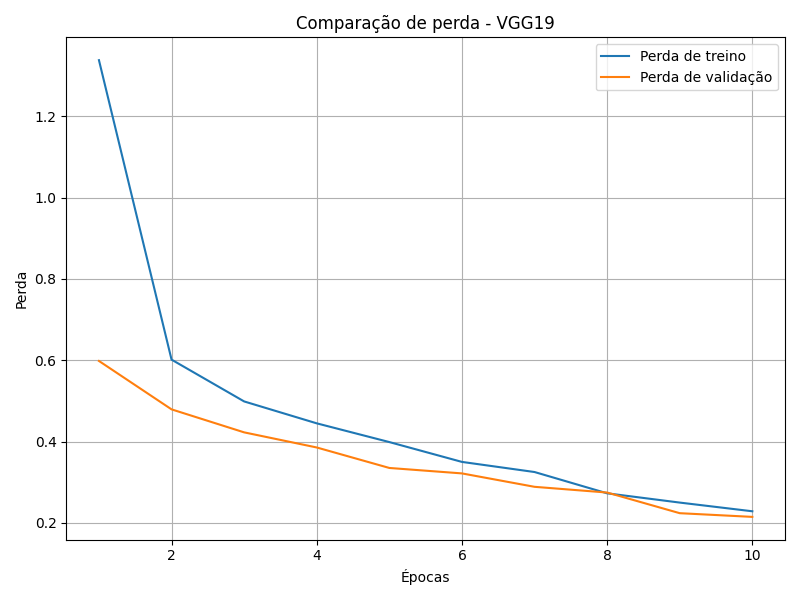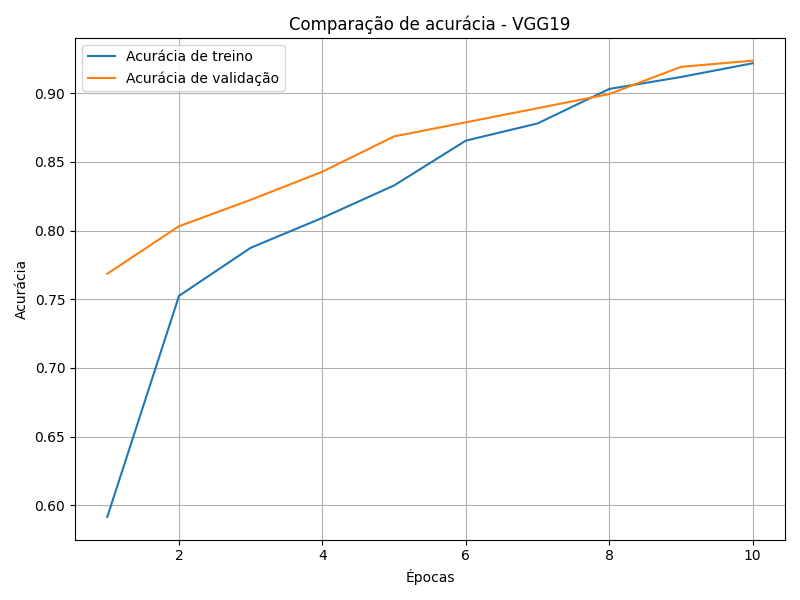


Olhando os resultados e os gráficos, podemos identificar que, embora a MobileNetV2 tenha apresentado a melhor acurácia de treino (99%), isso não se refletiu durante a validação, o que fez com que ela sofresse de overfitting. Além disso, ao observarmos o gráfico de loss desse mesmo modelo, vemos que, durante a validação, o erro é muito grande em relação ao valor esperado.

Avaliando o próximo modelo, o ResNet50, podemos identificar problemas similares aos do modelo anterior.

Já o último modelo, o VGG19, não foi o modelo com a maior acurácia de treinamento. Ao contrário dos modelos anteriores, ele nem chegou a ultrapassar os 93%. Porém, sua capacidade de normalização foi superior, apresentando ótimos resultados de validação e a maior acurácia de teste. Além disso, as perdas, em todas as épocas, foram baixas, indicando que, mesmo quando o modelo erra, o valor estimado se aproxima bastante do valor esperado.

Vale ressaltar que foi utilizado o mesmo processo de preparação de dados e customização de modelo para todas as redes neurais testadas, o que pode ter influenciado diretamente os resultados